Re-starting from epoch 36
Processing 1 images
image                    shape: (1262, 1262, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 2560, 2560, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 2560.00000  float64
anchors                  shape: (1, 1636800, 4)       min:   -0.14148  max:    1.11647  float32


/home/ettore/.miniconda3/envs/kiwi/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-01-29 18:00:09.654221: W tensorflow/c/c_api.cc:305] Operation '{name:'mrcnn_detection_3/Reshape_1' id:37008 op device:{requested: '', assigned: ''} def:{{{node mrcnn_detection_3/Reshape_1}} = Reshape[T=DT_FLOAT, Tshape=DT_INT32, _has_manual_control_dependencies=true](mrcnn_detection_3/packed, mrcnn_detection_3/Reshape_1/shape)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


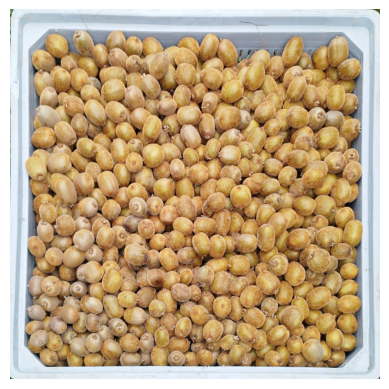

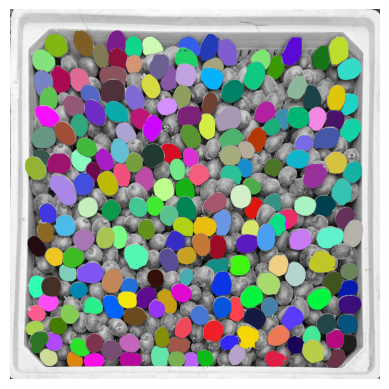

In [7]:
import os
import sys
import random
import numpy as np
import tensorflow as tf
import cv2

ROOT_DIR = os.path.abspath("")

# Import Mask-RCNN
sys.path.append(ROOT_DIR)
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import skimage.draw

import matplotlib.pyplot as plt

import kiwi

# Directory to save logs and trained model
# MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Weights path 36,66,99
WEIGHTS_PATH = os.path.join(
    ROOT_DIR, "logs", "kiwi20240128T1953", "mask_rcnn_kiwi_0036.h5"
)

IMGS_PATH = os.path.join(os.path.abspath("../../../"), "dataset", "selected")


def show_image(img, title: str = ""):
    if len(img.shape) == 3:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_GRAY2RGB))

    plt.axis("off")
    if title != "":
        plt.title(title)
    plt.show()


config = kiwi.KiwiInferenceConfig()
model = modellib.MaskRCNN(mode="inference", config=config, model_dir="logs/")

model.load_weights(
    WEIGHTS_PATH,
    by_name=True,
    # exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"],
)

def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)

    splash = np.zeros_like(image)

    for i in range(mask.shape[-1]):
        color = np.random.randint(0, 256, 3)  # Random RGB color
        mask_single = mask[:, :, i]

        # Convert boolean mask to uint8
        mask_single = mask_single.astype(np.uint8)

        # Create a color mask
        color_mask = np.zeros_like(image)
        color_mask[:, :, :] = color

        # Apply color mask to the splash image
        splash += cv2.bitwise_and(
            color_mask, color_mask, mask=mask_single[:, :, np.newaxis]
        )

    # Combine the colored mask with the grayscale image
    splash = np.where(np.sum(mask, axis=-1, keepdims=True) >= 1, splash, gray).astype(
        np.uint8
    )

    return splash


def detect_and_color_splash(model, image):
    # Detect objects
    r = model.detect([image], verbose=1)[0]

    # Color splash
    splash = color_splash(image, r["masks"])
    return splash


image = cv2.imread(os.path.join(IMGS_PATH, "0.png"))
# image = skimage.io.imread(os.path.join(IMGS_PATH, "0.png"))
masked = detect_and_color_splash(model, image)

show_image(image)
show_image(masked)


In [4]:
r = model.detect([image])[0]

In [6]:
r['scores']

array([0.9969369 , 0.99582684, 0.99578655, 0.9942878 , 0.994277  ,
       0.99407846, 0.9934944 , 0.99347603, 0.9929538 , 0.9927973 ,
       0.99250335, 0.9924278 , 0.9917117 , 0.99153954, 0.9914386 ,
       0.9907522 , 0.98976254, 0.9891947 , 0.98917806, 0.989139  ,
       0.98913115, 0.98887104, 0.9884943 , 0.9881924 , 0.9880098 ,
       0.98796153, 0.9878417 , 0.9871626 , 0.9866524 , 0.9862858 ,
       0.9862095 , 0.9859065 , 0.98505855, 0.98474884, 0.98442054,
       0.9831923 , 0.982924  , 0.9826829 , 0.9822397 , 0.9820209 ,
       0.98150045, 0.9809101 , 0.9806134 , 0.9805244 , 0.9803056 ,
       0.9791879 , 0.97883093, 0.97750694, 0.97731286, 0.9768059 ,
       0.9765786 , 0.97578216, 0.97525024, 0.9749171 , 0.97450054,
       0.97419703, 0.9727247 , 0.9726806 , 0.9720705 , 0.9718854 ,
       0.97049284, 0.96973747, 0.9696144 , 0.96954936, 0.9690154 ,
       0.9680508 , 0.966885  , 0.96610504, 0.96260434, 0.9625672 ,
       0.96058345, 0.96044713, 0.9596402 , 0.952718  , 0.95246

In [10]:
import pickle
with open('mrcnn_single_out.pickle', 'wb') as f:
    pickle.dump(r, f, pickle.HIGHEST_PROTOCOL)